In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import os

In [5]:
from config import DATA_DIR

trends_file = PROJECT_ROOT / DATA_DIR / "processed" / "trends_daily.csv"
overlap_log_file = PROJECT_ROOT / DATA_DIR / "processed" / "overlap_scaling_log.csv"

figures_dir = PROJECT_ROOT / "figures" / "trends"
os.makedirs(figures_dir, exist_ok=True)

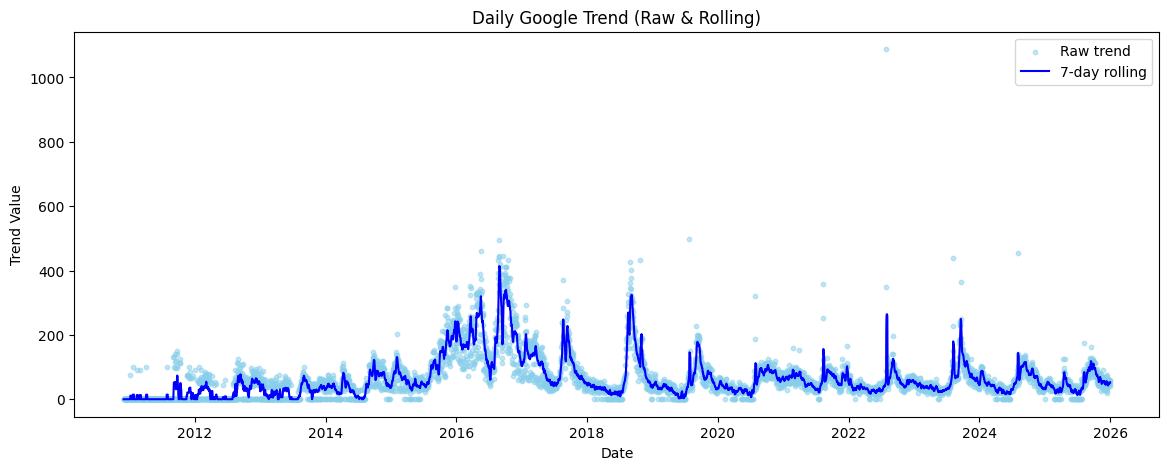

In [6]:
trends = pd.read_csv(trends_file, parse_dates=['date'])
trends = trends.set_index('date').asfreq('D')

ROLL_WINDOW = 7
trends['trend_roll'] = trends['trend'].interpolate(limit=7).rolling(ROLL_WINDOW, min_periods=1).mean()

plt.figure(figsize=(14,5))
plt.scatter(trends.index, trends['trend'], s=10, alpha=0.5, color='skyblue', label='Raw trend')
plt.plot(trends.index, trends['trend_roll'], color='blue', label=f'{ROLL_WINDOW}-day rolling')
plt.title("Daily Google Trend (Raw & Rolling)")
plt.ylabel("Trend Value")
plt.xlabel("Date")
plt.legend()

plt.savefig(figures_dir / "daily-google-trend.png")
plt.show()

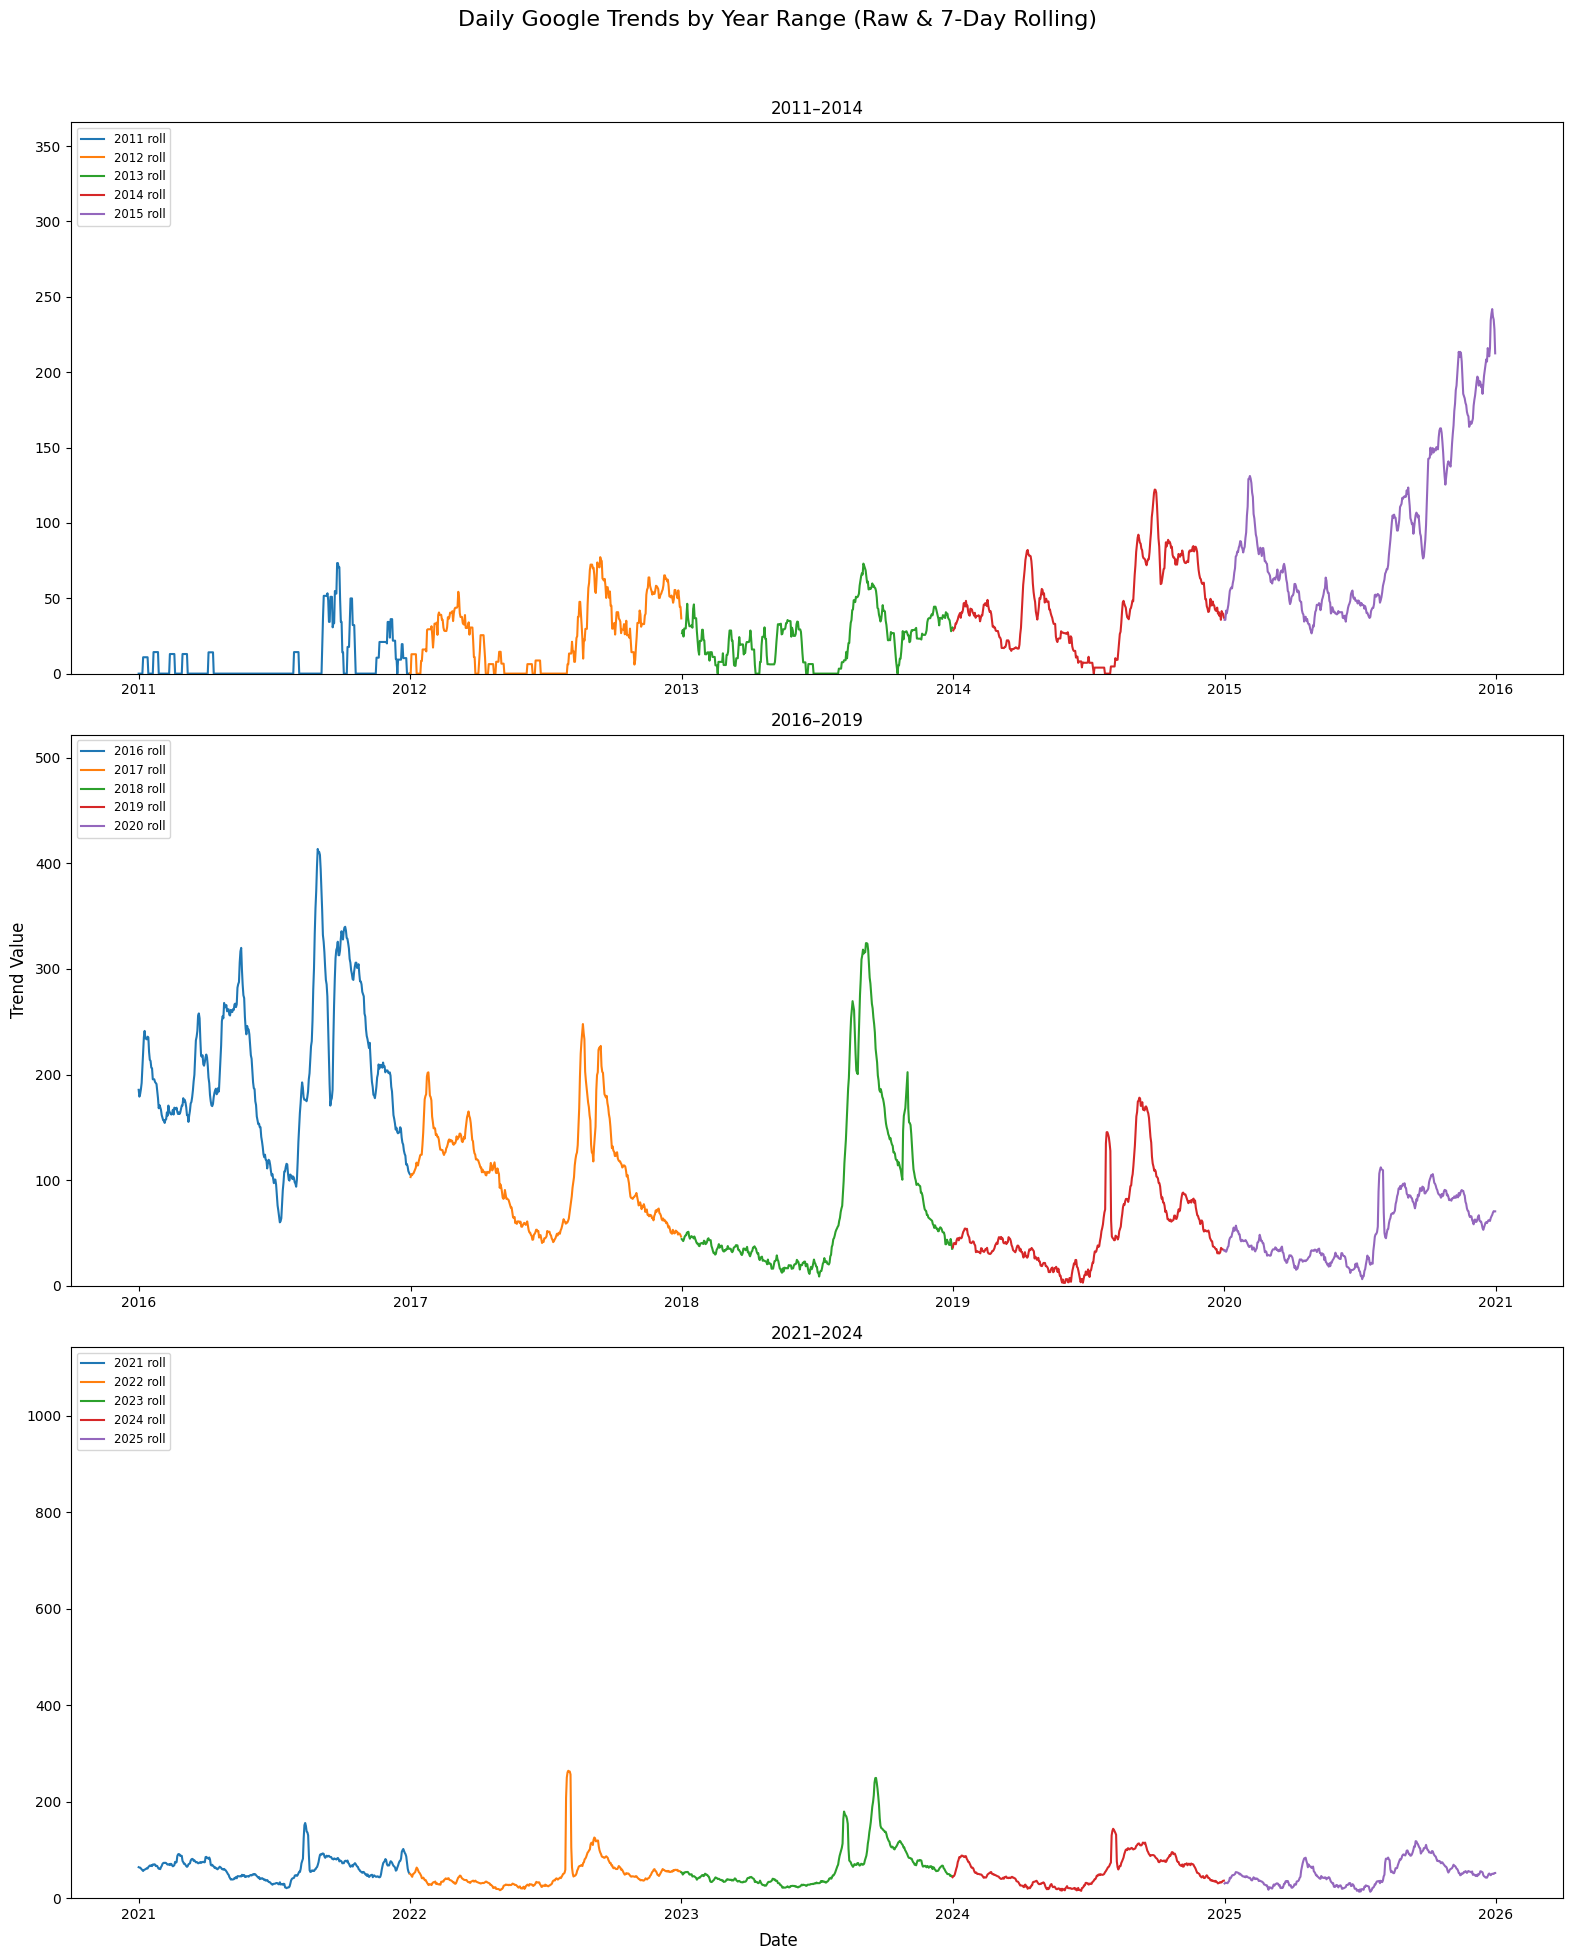

In [7]:
trends = pd.read_csv(trends_file, parse_dates=['date'])
trends = trends.set_index('date').asfreq('D')

ROLL_WINDOW = 7
trends['trend_roll'] = trends['trend'].interpolate(limit=7).rolling(ROLL_WINDOW, min_periods=1).mean()

trends['year'] = trends.index.year
trends['day_of_year'] = trends.index.dayofyear

year_ranges = [
    range(2011, 2016),
    range(2016, 2021),
    range(2021, 2026)
]

fig, axes = plt.subplots(len(year_ranges), 1, figsize=(16, 20))

for ax, yr_range in zip(axes, year_ranges):
    max_val = 0
    for year in yr_range:
        group = trends[trends['year'] == year]
        if not group.empty:
            ax.plot(group.index, group['trend_roll'], linewidth=1.5, label=f'{year} roll')
            max_val = max(max_val, group['trend'].max(), group['trend_roll'].max())
    
    ax.set_ylim(0, max_val*1.05)
    ax.set_title(f"{min(yr_range)}–{max(yr_range)-1}")
    ax.legend(fontsize='small', loc='upper left')

fig.suptitle(f"Daily Google Trends by Year Range (Raw & {ROLL_WINDOW}-Day Rolling)", fontsize=16)
fig.supxlabel("Date")
fig.supylabel("Trend Value")
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(figures_dir / "daily-google-trend-byyears.png")
plt.show()

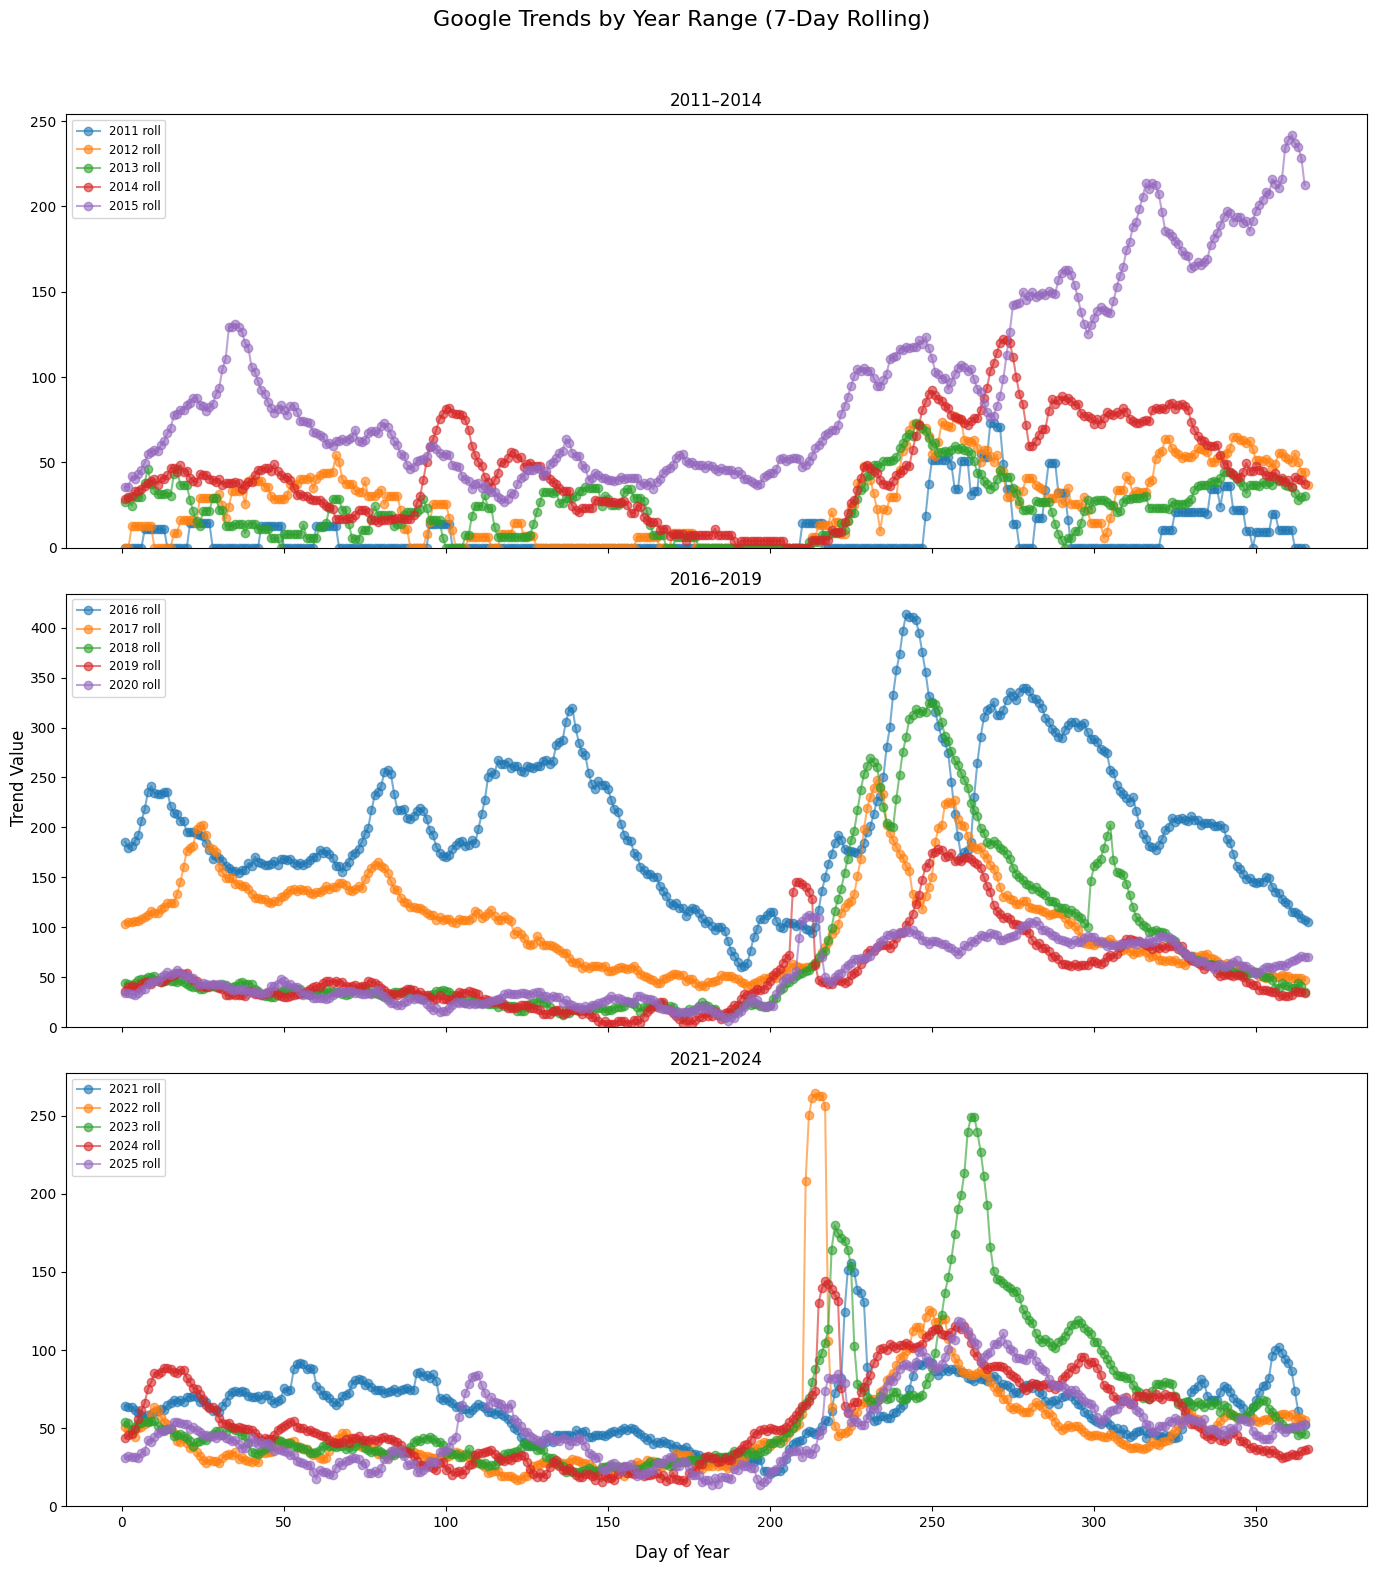

In [ ]:
trends = pd.read_csv(trends_file, parse_dates=['date'])
trends = trends.set_index('date').asfreq('D')

ROLL_WINDOW = 7
trends['trend_roll'] = trends['trend'].interpolate(limit=7).rolling(ROLL_WINDOW, min_periods=1).mean()

trends['Year'] = trends.index.year
trends['DayOfYear'] = trends.index.dayofyear

year_ranges = [
    range(2011, 2016),
    range(2016, 2021),
    range(2021, 2026)
]

fig, axes = plt.subplots(len(year_ranges), 1, figsize=(14, 16), sharex=True)

for ax, yr_range in zip(axes, year_ranges):
    max_val = 0  # track max for y-limit
    for year in yr_range:
        group = trends[trends['Year'] == year]
        if not group.empty:
            ax.plot(group['DayOfYear'], group['trend_roll'], marker='o', linestyle='-', alpha=0.6, label=f'{year} roll')
            max_val = max(max_val, group['trend_roll'].max())
    
    ax.set_ylim(0, max_val * 1.05)
    ax.set_title(f"{min(yr_range)}–{max(yr_range)-1}")
    ax.legend(fontsize='small', loc='upper left')

fig.suptitle(f"Google Trends by Year Range ({ROLL_WINDOW}-Day Rolling)", fontsize=16)
fig.supxlabel("Day of Year")
fig.supylabel("Trend Value")
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

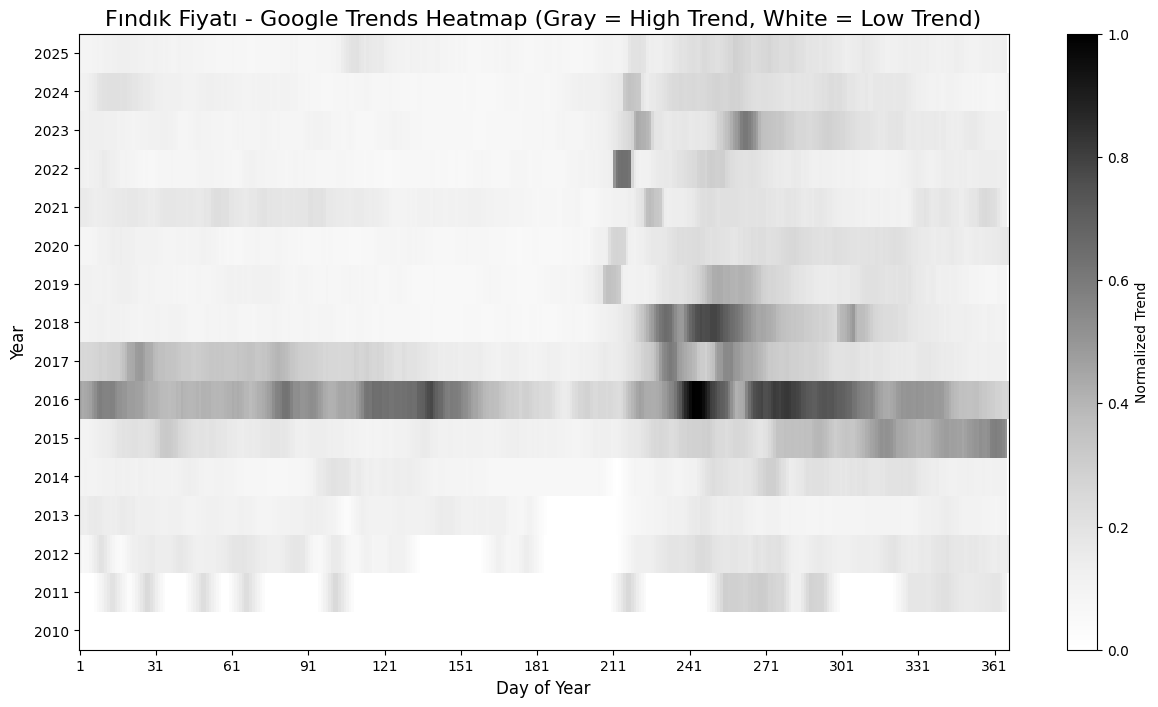

In [8]:
trends = pd.read_csv(trends_file, parse_dates=['date'])
trends = trends.set_index('date').asfreq('D')

ROLL_WINDOW = 7
trends['trend_smooth'] = trends['trend'].replace(0, np.nan).interpolate(limit=7).fillna(0)
trends['trend_smooth'] = trends['trend_smooth'].rolling(ROLL_WINDOW, min_periods=1).mean()

trends['trend_norm'] = trends['trend_smooth'] / trends['trend_smooth'].max()

trends['day_of_year'] = trends.index.dayofyear
trends['year'] = trends.index.year

heatmap_data = trends.pivot_table(
    values='trend_norm',
    index='year',
    columns='day_of_year',
    aggfunc='first'
)

heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(15, 8))
norm = Normalize(vmin=0, vmax=1)
plt.imshow(
    heatmap_data,
    cmap='Greys',
    aspect='auto',
    interpolation='none',
    origin='lower',
    norm=norm
)

plt.title('Fındık Fiyatı - Google Trends Heatmap (Gray = High Trend, White = Low Trend)', fontsize=16)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel('Year', fontsize=12)

plt.xticks(
    ticks=np.arange(0, 365, 30),
    labels=[str(i+1) for i in range(0, 365, 30)]
)

plt.yticks(
    ticks=np.arange(len(heatmap_data.index)),
    labels=heatmap_data.index
)

plt.colorbar(label='Normalized Trend')

plt.savefig(figures_dir / "google-trend-heatmap.png")
plt.show()

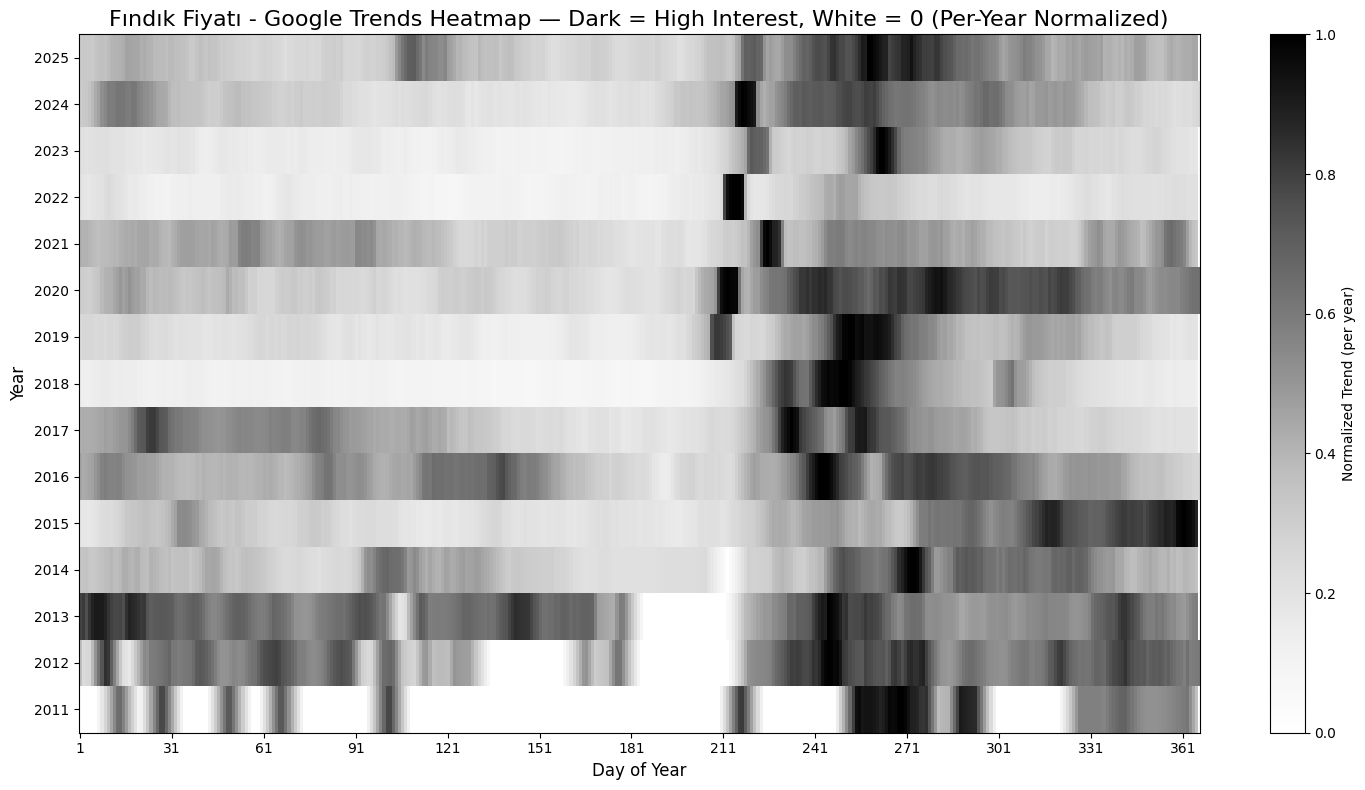

In [9]:
trends = pd.read_csv(trends_file, parse_dates=['date'])
trends = trends.set_index('date').asfreq('D')

ROLL_WINDOW = 7
trends['trend_smooth'] = trends['trend'].replace(0, np.nan).interpolate(limit=7).fillna(0)
trends['trend_smooth'] = trends['trend_smooth'].rolling(ROLL_WINDOW, min_periods=1).mean()

trends['year'] = trends.index.year
trends['day_of_year'] = trends.index.dayofyear

trends['trend_norm_year'] = trends.groupby('year')['trend_smooth'].transform(lambda x: x / x.max())

heatmap_data = trends.pivot_table(
    values='trend_norm_year',
    index='year',
    columns='day_of_year',
    aggfunc='first'
).fillna(0)
plt.figure(figsize=(15, 8))
norm = Normalize(vmin=0, vmax=1)
plt.imshow(
    heatmap_data,
    cmap='Greys',
    aspect='auto',
    interpolation='none',
    origin='lower',
    norm=norm
)

plt.title('Fındık Fiyatı - Google Trends Heatmap — Dark = High Interest, White = 0 (Per-Year Normalized)', fontsize=16)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel('Year', fontsize=12)

plt.xticks(
    ticks=np.arange(0, 365, 30),
    labels=[str(i+1) for i in range(0, 365, 30)]
)
plt.yticks(
    ticks=np.arange(len(heatmap_data.index)),
    labels=heatmap_data.index
)

plt.colorbar(label='Normalized Trend (per year)')
plt.tight_layout()

plt.savefig(figures_dir / "google-trend-heatmap-onyears.png")
plt.show()

**Overlapping Scaling Analysis**


In [ ]:
overlap = pd.read_csv(overlap_log_file)
overlap.describe()

,window_index,overlap_days,valid_ratios,median_ratio,ratio_min,ratio_max,ratio_std
count,68.00000,68.0,68.000000,68.000000,64.000000,64.000000,6.100000e+01
mean,34.50000,11.0,8.926471,1.959326,1.968131,2.087403,4.359392e-02
std,19.77372,0.0,3.588190,1.698923,1.643233,1.880326,1.086368e-01
min,1.00000,11.0,0.000000,0.534306,0.518115,0.542554,7.021667e-17
25%,17.75000,11.0,9.000000,0.855538,0.819340,0.851817,6.532561e-03
50%,34.50000,11.0,11.000000,1.252127,1.347041,1.388202,1.498181e-02
75%,51.25000,11.0,11.000000,2.976877,3.040367,3.128411,2.756524e-02
max,68.00000,11.0,11.000000,10.876897,9.955126,12.167377,7.997320e-01


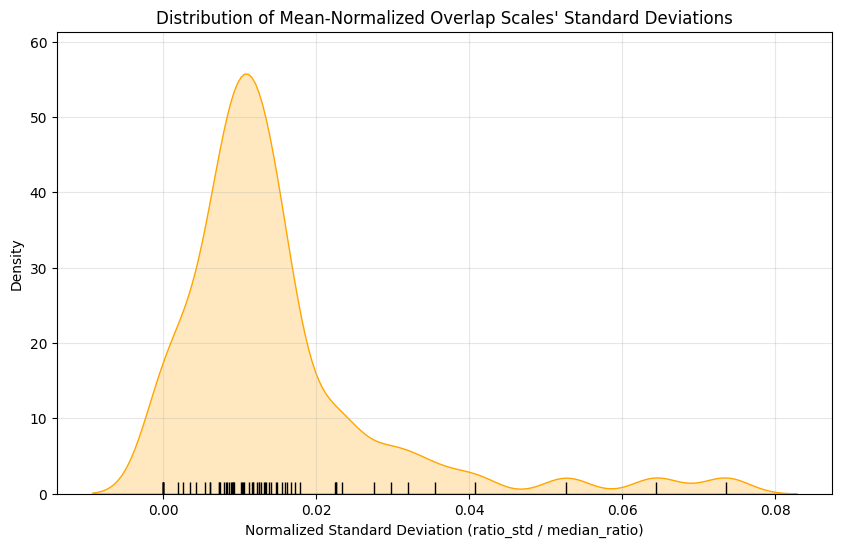

In [ ]:
overlap['median_ratio'] = overlap['median_ratio'].replace(0, 1e-6)
overlap['ratio_std_norm'] = overlap['ratio_std'] / overlap['median_ratio']

plt.figure(figsize=(10,6))
sns.kdeplot(overlap['ratio_std_norm'], fill=True, color='orange', bw_adjust=0.5)
sns.rugplot(overlap['ratio_std_norm'], color='black')
plt.title("Distribution of Mean-Normalized Overlap Scales' Standard Deviations")
plt.xlabel("Normalized Standard Deviation (ratio_std / median_ratio)")
plt.ylabel("Density")
plt.grid(alpha=0.3)

plt.savefig(figures_dir / "overlap_scale_std_kde.png")
plt.show()